### 0.导入函数库

In [1]:
%matplotlib inline
from obspy.core import read
from obspy.core import UTCDateTime
from obspy import read_inventory
from obspy.imaging.cm import pqlx
from obspy.signal.invsim import cosine_taper 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from utilities.plot_tools import plot_fft
from utilities.utils import design_filter
from utilities.plot_tools import filter_and_plot
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams.update({# Use mathtext, not LaTeX
                            'text.usetex': False,
                            # Use the Computer modern font
                            'font.family': 'serif',
                            'font.serif': 'cmr10',
                            'mathtext.fontset': 'cm',
                            # Use ASCII minus
                            'axes.unicode_minus': False,
                            })

### 1.滤波器
在地震学中，滤波器用于校正仪器响应，避免混叠效应，将“期望的”频率与“非期望的”频率分离，识别谐波信号，模拟特定的记录仪器等。对于滤波器并没有明确的分类。粗略地说，我们可以区分线性与非线性、模拟（电路、电阻、导线）与数字（逻辑元件）以及连续与离散滤波器。在地震学中，我们通常避免使用非线性滤波器，因为它们的输出包含输入信号中没有的频率。模拟滤波器可以是连续或离散的，而数字滤波器总是离散的。离散滤波器可以分为无限冲激响应（IIR）滤波器和有限冲激响应（FIR）滤波器。IIR滤波器是递归和因果的，而FIR滤波器是非递归、因果或非因果的。一些滤波器有特定的名称，例如Butterworth、Chebyshev或Bessel滤波器，但它们也可以被包含在上述分类中。<br>
有4种主要类型的滤波器：低通滤波器、高通滤波器、带通滤波器和带阻滤波器。低通和高通滤波器只有一个截止频率，分别允许低于和高于该截止频率的频率通过滤波器。相比之下，带通和带阻滤波器具有两个截止频率，分别定义了一个频率带用于通过和阻止。<br>
**进行滤波可以增加信噪比，但必须小心，确保没有破坏或改变关心的东西（如时间或振幅）**
```
滤波器通过其频率响应函数来描述，该函数是输出信号的傅里叶变换除以输入信号的傅里叶变换。
注意，选择滤波器的阶数需要权衡滤波效果和计算复杂度之间的关系。较高的阶数可能会增加计算负担，并且可能不一定总是产生更好的滤波结果。因此，需要根据具体应用场景和要求进行选择。
```

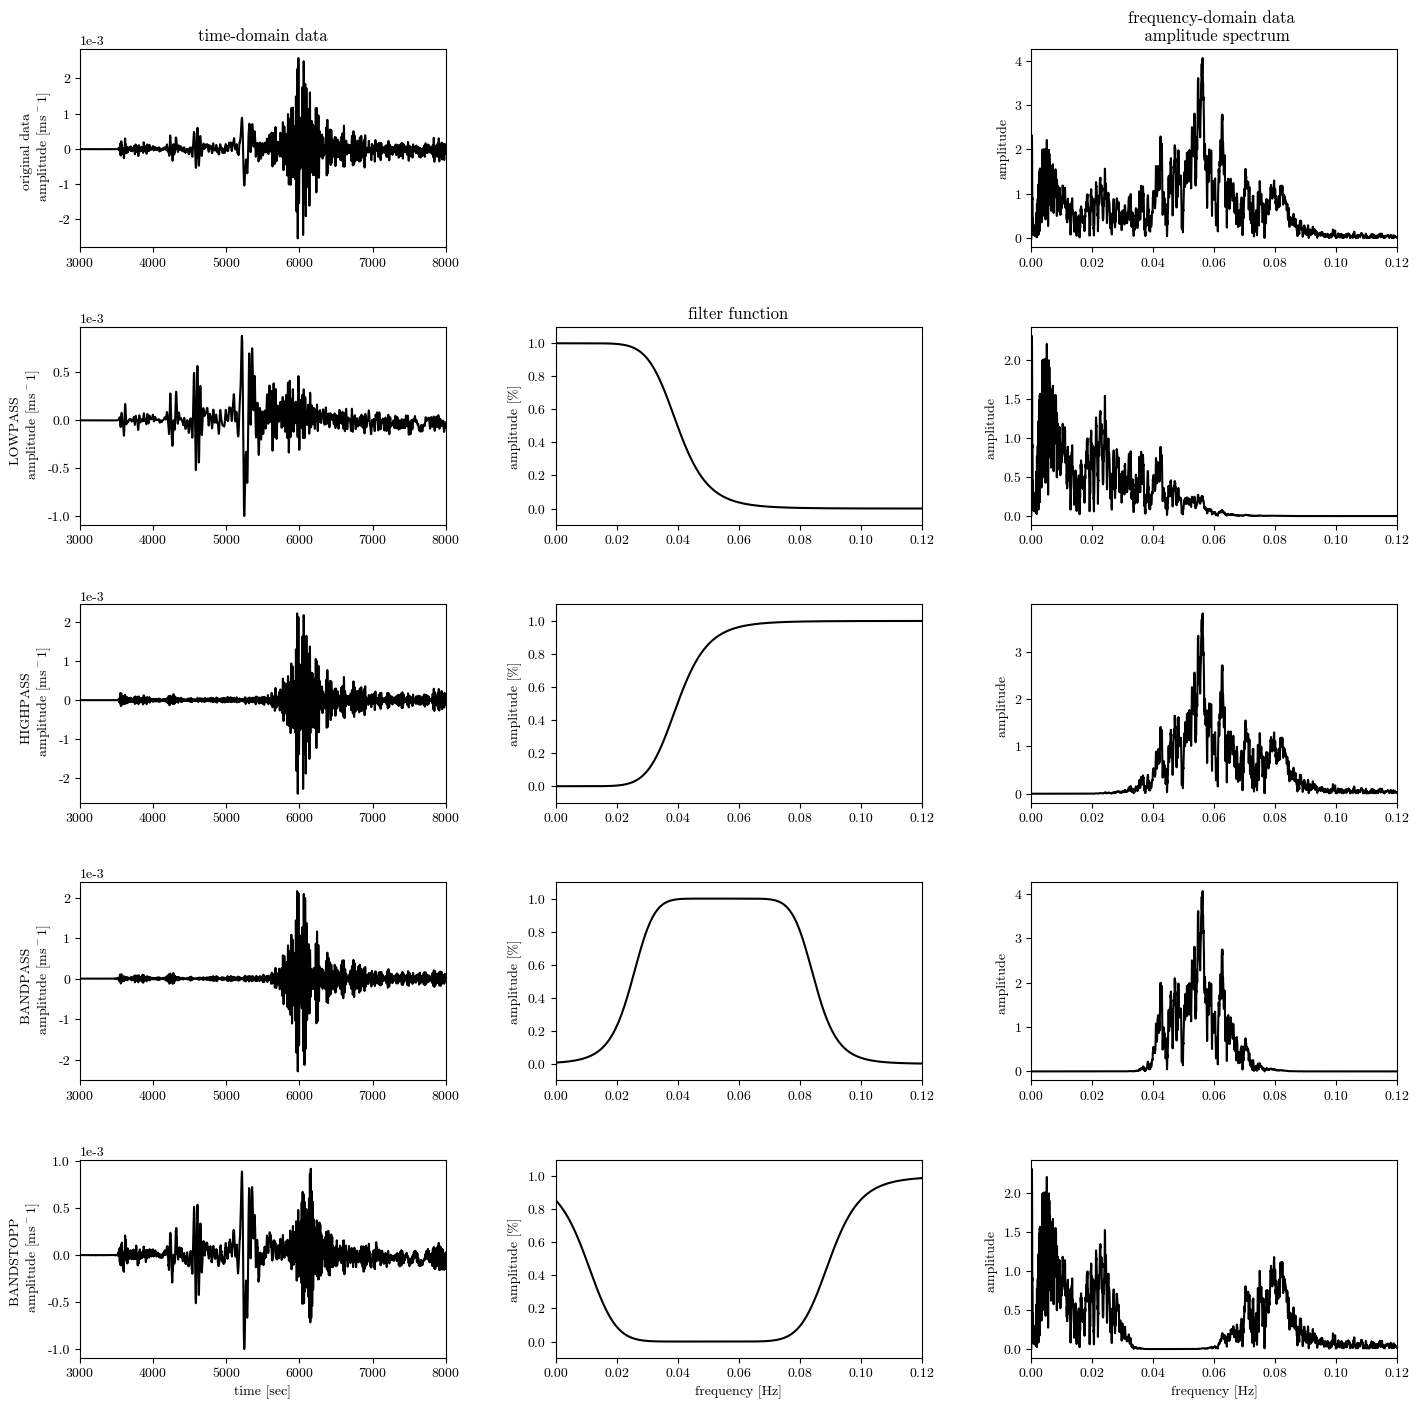

In [2]:
st = read("../data/spect_trace.mseed")
# 去仪器响应
inv = read_inventory("../data/GR.WET.xml")
st.remove_response(output="VEL", inventory=inv)
st.detrend('linear')
st.detrend('demean')

# 滤波器类型
npts = st[0].stats.npts                   # 样本数量
dt = st[0].stats.delta                    # 采样间隔
fNy = 1. / (2. * dt)                      # 奈奎斯频率
time = np.arange(0, npts) * dt            # 时间轴
freq = np.linspace(0, fNy, npts // 2 + 1) # 频率轴
corners = 4                               # 滤波器阶数
# 不同滤波器类型的几个滤波频率
f0 = 0.04
fmin1 = 0.04
fmax1 = 0.07
fmin2 = 0.03
fmax2 = 0.07

# 滤波器函数
LP = 1 / ( 1 + (freq / f0) ** (2 * corners))
HP = 1 - 1 / (1 + (freq / f0) ** (2 * corners))
wc = fmax1 - fmin1
wb = 0.5 * wc + fmin1
BP = 1/(1 + ((freq - wb) / wc) ** (2 * corners))
wc = fmax2 - fmin2
wb = 0.5 * wc + fmin2
BS = 1 - ( 1 / (1 + ((freq - wb) / wc) ** (2 * corners)))

# 滤波
stHP = st.copy()
stHP.filter('highpass', freq=f0, corners=corners, zerophase=True)
stLP = st.copy()
stLP.filter('lowpass', freq=f0, corners=corners, zerophase=True)
stBP = st.copy()
stBP.filter('bandpass', freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
stBS = st.copy()
stBS.filter('bandstop', freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)

# 振幅普
Ospec = np.fft.rfft(st[0].data)
LPspec = np.fft.rfft(stLP[0].data)
HPspec = np.fft.rfft(stHP[0].data)
BPspec = np.fft.rfft(stBP[0].data)
BSspec = np.fft.rfft(stBS[0].data)

# 绘图
plt.rcParams['figure.figsize'] = 17, 17
tx1 = 3000
tx2 = 8000
fx2 = 0.12

fig = plt.figure()

ax1 = fig.add_subplot(5,3,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, st[0].data, 'k')
plt.xlim(tx1, tx2)
plt.title('time-domain data')
plt.ylabel('original data \n amplitude [ms$^-1$]')

ax3 = fig.add_subplot(5,3,3)
plt.plot(freq, abs(Ospec), 'k')
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
plt.xlim(0,fx2)

ax4 = fig.add_subplot(5,3,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stLP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('LOWPASS  \n amplitude [ms$^-1$]')

ax5 = fig.add_subplot(5,3,5)
plt.plot(freq, LP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.title('filter function')
plt.ylabel('amplitude [%]')

ax6 = fig.add_subplot(5,3,6)
plt.plot(freq, abs(LPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax7 = fig.add_subplot(5,3,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stHP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('HIGHPASS  \n amplitude [ms$^-1$]')

ax8 = fig.add_subplot(5,3,8)
plt.plot(freq, HP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax9 = fig.add_subplot(5,3,9)
plt.plot(freq, abs(HPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax10 = fig.add_subplot(5,3,10)
ax10.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('BANDPASS  \n amplitude [ms$^-1$]')

ax11 = fig.add_subplot(5,3,11)
plt.plot(freq, BP, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax12 = fig.add_subplot(5,3,12)
plt.plot(freq, abs(BPspec), 'k')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

ax13 = fig.add_subplot(5,3,13)
ax13.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBS[0].data, 'k')
plt.xlim(tx1, tx2)
plt.xlabel('time [sec]')
plt.ylabel('BANDSTOPP \n amplitude [ms$^-1$]')

ax14 = fig.add_subplot(5,3,14)
plt.plot(freq, BS, 'k', linewidth=1.5)
plt.xlim(0,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('frequency [Hz]')

ax15 = fig.add_subplot(5,3,15)
plt.plot(freq, abs(BSspec), 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude ')
plt.xlim(0,fx2)

plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

### 2.因果滤波器

对于一个因果滤波器，它的输出信号只依赖于过去和当前的输入信号，而不依赖于未来的输入信号。这种因果性质使得滤波器的相位不是零相位，即滤波器引入了一定的相位延迟。
在某些应用中，保留信号的相位信息非常重要。需要注意的是，较高阶数的滤波器可能会引入更大的相位延迟和畸变。根据具体的应用需求，可以选择不同阶数和类型的滤波器来平衡相位特性和滤波效果。低阶滤波器通常引入较小的相位延迟，而高阶滤波器可能引入更大的相位延迟但提供更陡峭的滤波特性。
因此，在选择滤波器时，需要考虑到应用的需求，并权衡滤波器的因果性、相位特性和滤波效果之间的取舍。

```
对信号应用滤波器时，可以分别向前和向后应用滤波器。这样做会导致滤波器的阶数加倍，但最终得到的滤波后的迹波形不会发生相位移动，也就是零相位移。
通过这种方式，我们可以获得零相位滤波的效果，其中滤波器对信号的影响在时间上是对称的，不会引入相位偏移。这对于某些应用场景非常重要，特别是当需要保持信号的时间对称性或需要准确的相位信息时。
```

(1)相位变换滤波器的相位来改变

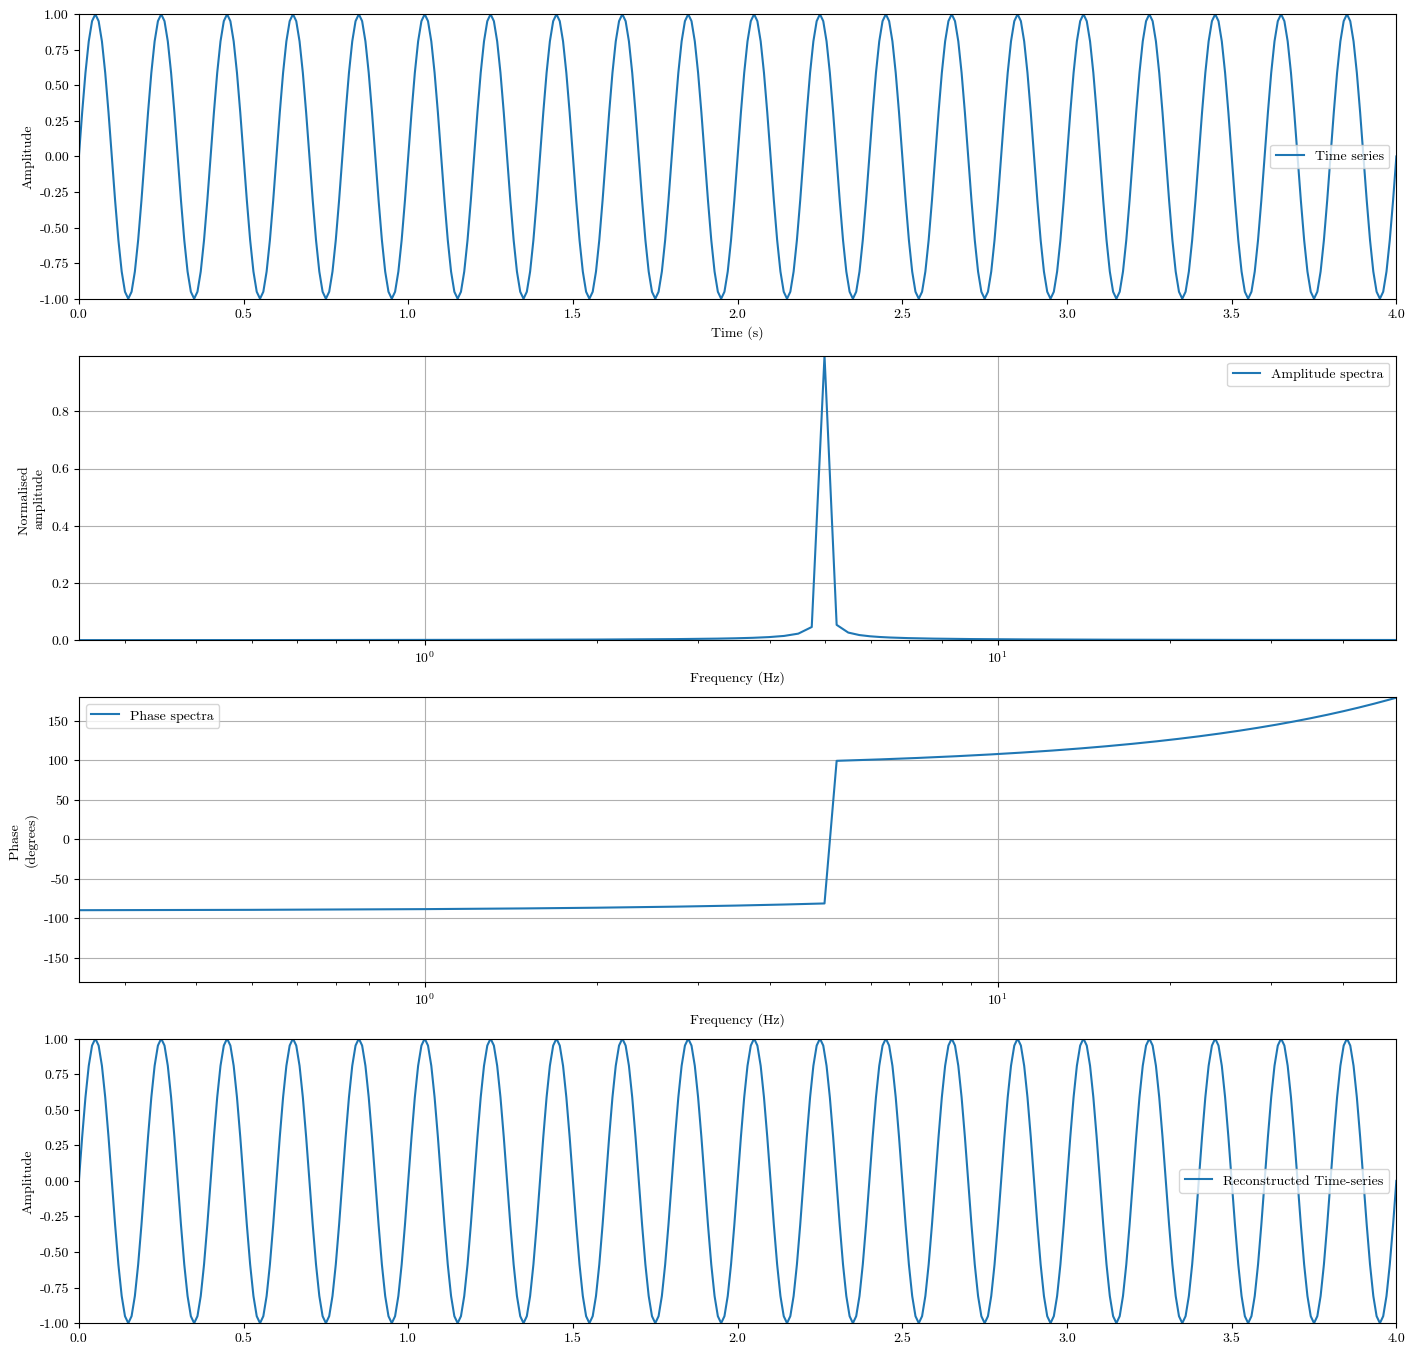

In [3]:
sample_frequency = 100
dt = 1 / sample_frequency
sine_freq = 5
x = np.arange(0.0, 20 * (1 / sine_freq) + dt, dt)
x += (0.0 * np.pi)  # Changing the starting value of x will effectively phase-shift your sine wave. Try changing this and observing the shift in the phase spectrum.

y = np.sin(x * sine_freq * (2 * np.pi))

fig = plot_fft(x, y, log_y=False, plot_phase=True)

(2)真实数据相位变换
```
从信号中分解出的每个正弦波的时间偏移
```

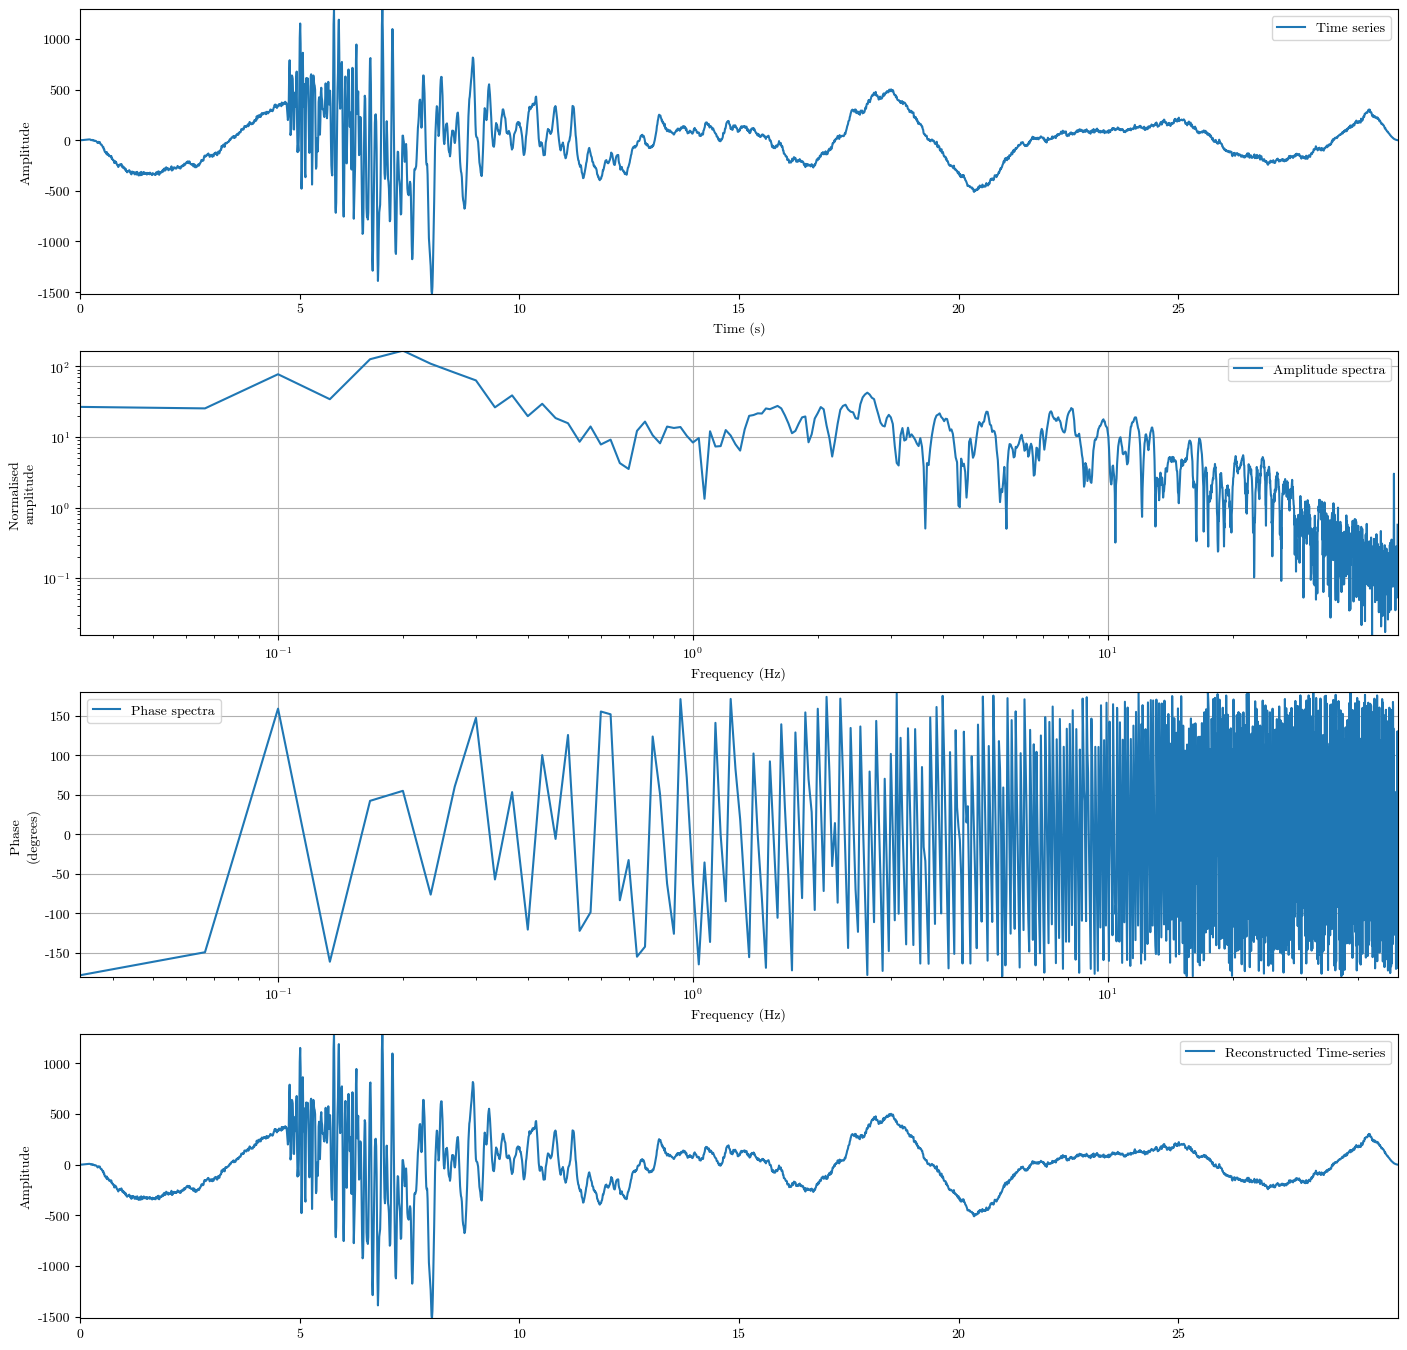

In [4]:
st = read("../data/test_trace.mseed")
tr = st[0]
tr = read()[0]
x = np.arange(0, tr.stats.npts * tr.stats.delta, tr.stats.delta)
y = tr.data

fig = plot_fft(x, y, plot_phase=True)

(3)分别向前和向后应用滤波器

BW.RJOB..EHZ | 2009-08-24T00:20:03.000000Z - 2009-08-24T00:20:32.990000Z | 100.0 Hz, 3000 samples


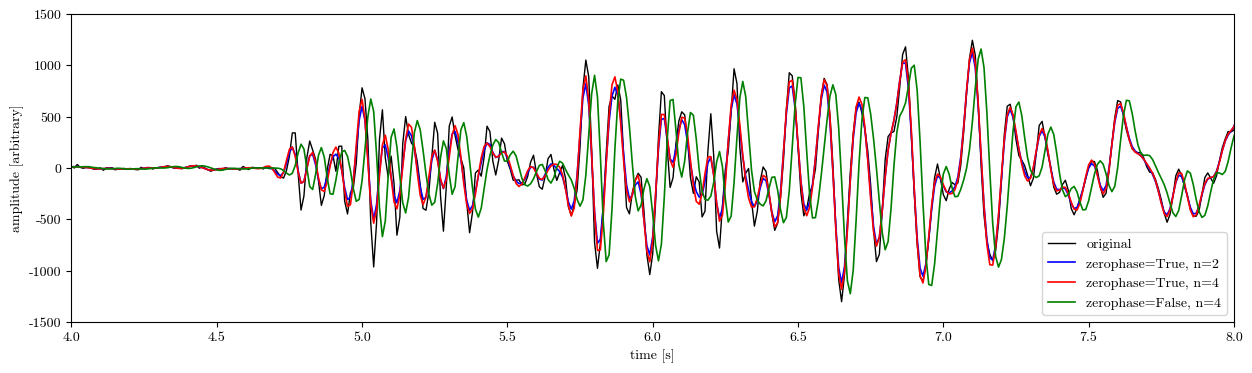

In [5]:
st = read('../data/filter_test_0.mseed')       
tr = st[0]                    
tr.detrend('demean')           
tr.detrend('linear')
tr.filter("highpass", freq=2)  # 移除长周期信号
print(tr)
t = tr.times()                 

f = 15.0                       # 滤波频率
start = 4                      # 开始时间
end = 8                        # 结束时间
amp = 1500                     # 振幅范围
ncorners = 4                   # 阶数

tr_filt1 = tr.copy() 
# 因果滤波器/零相位，阶数为2。           
tr_filt1.filter('lowpass', freq=f, zerophase=True, corners=ncorners/2)

tr_filt2 = tr.copy()   
# 因果滤波器/零相位，阶数为ncorners        
tr_filt2.filter('lowpass', freq=f, zerophase=True, corners=ncorners)

tr_filt3 = tr.copy() 
# 因果滤波器/非零相位，阶数为ncorners          
tr_filt3.filter('lowpass', freq=f, zerophase=False, corners=ncorners)

# 绘图
plt.rcParams['figure.figsize'] = 15, 4
plt.plot(t, tr.data, 'k', label='original', linewidth=1.)
plt.plot(t, tr_filt1.data, 'b', label='zerophase=True, n=2', linewidth=1.2)
plt.plot(t, tr_filt2.data, 'r', label='zerophase=True, n=%s' % ncorners, linewidth=1.2)
plt.plot(t, tr_filt3.data, 'g', label='zerophase=False, n=%s' % ncorners, linewidth=1.2)

plt.xlabel('time [s]')
plt.xlim(start, end)    
plt.ylim(-amp, amp)
plt.ylabel('amplitude [arbitrary]')
plt.legend(loc='lower right')

plt.show()

### 3.远震带通滤波
```
在不同的频率带中，会看到不同的特征。每个频率带都突出显示了不同频率范围内的信号成分。较低的频率带可能显示出长周期的振动，而较高的频率带可能显示出更短周期的振动。这可以帮助我们分析信号的频率内容并识别出不同的地震事件特征。
```

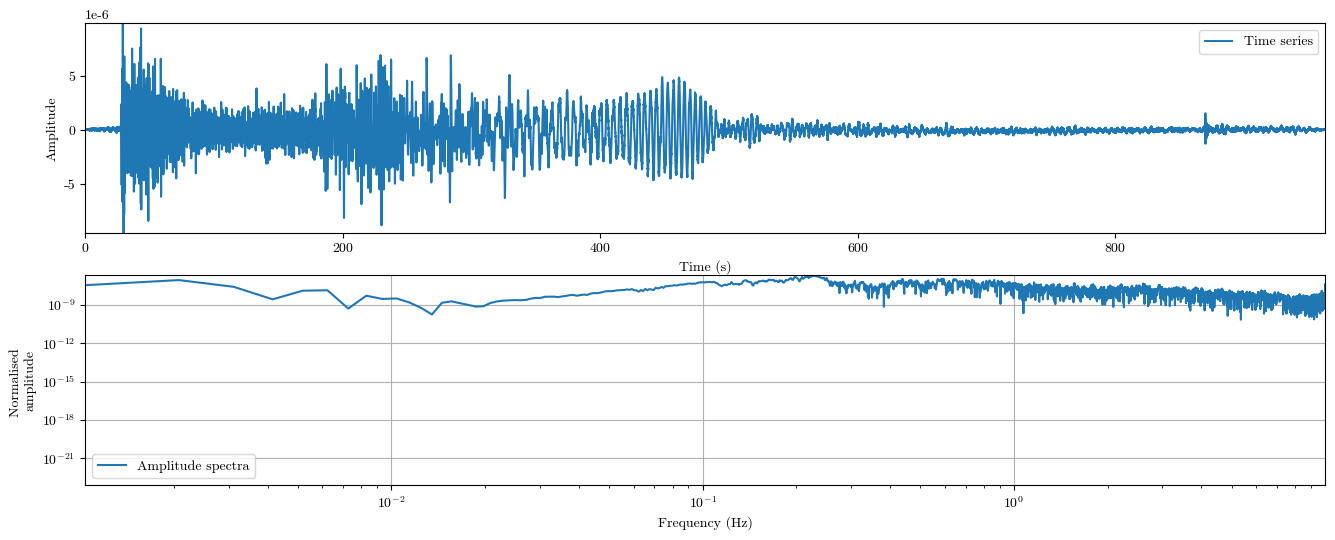

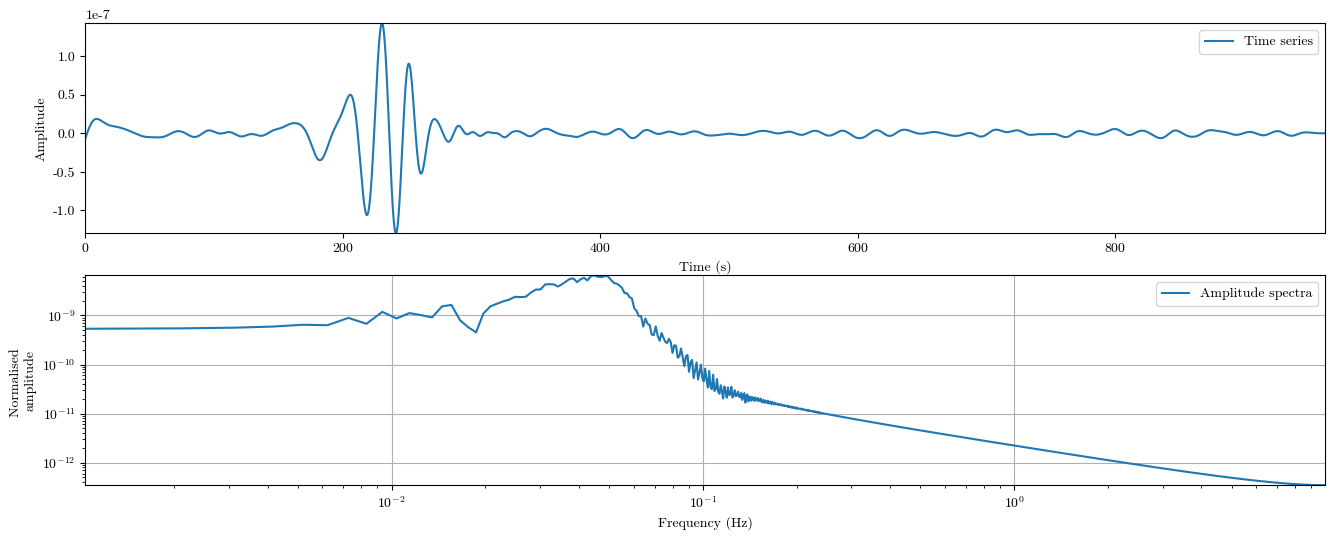

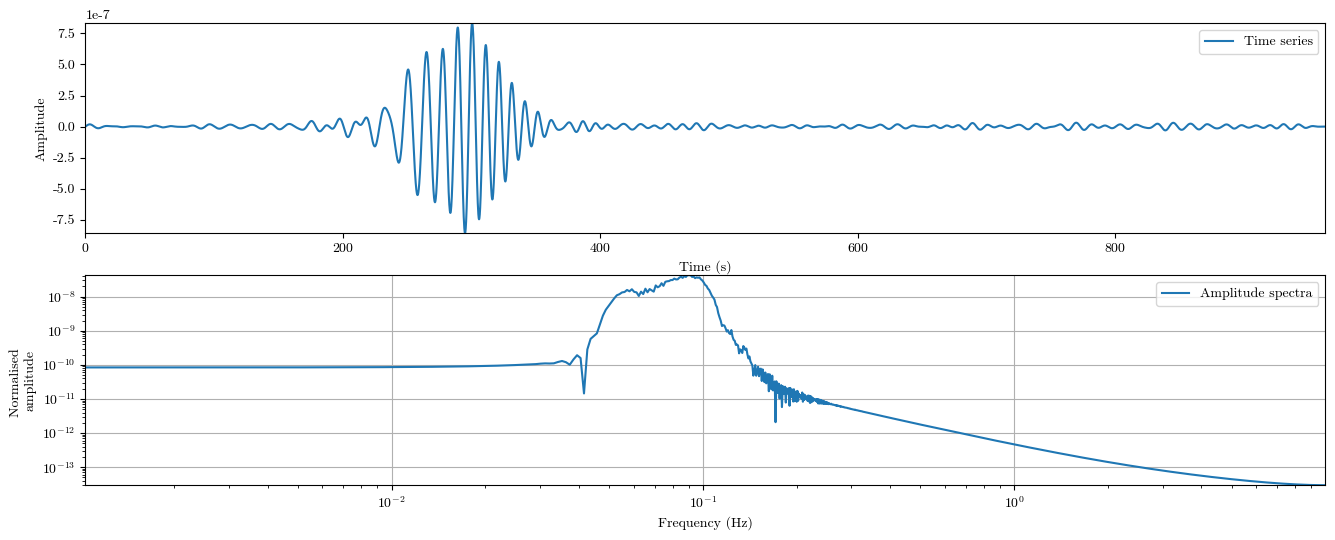

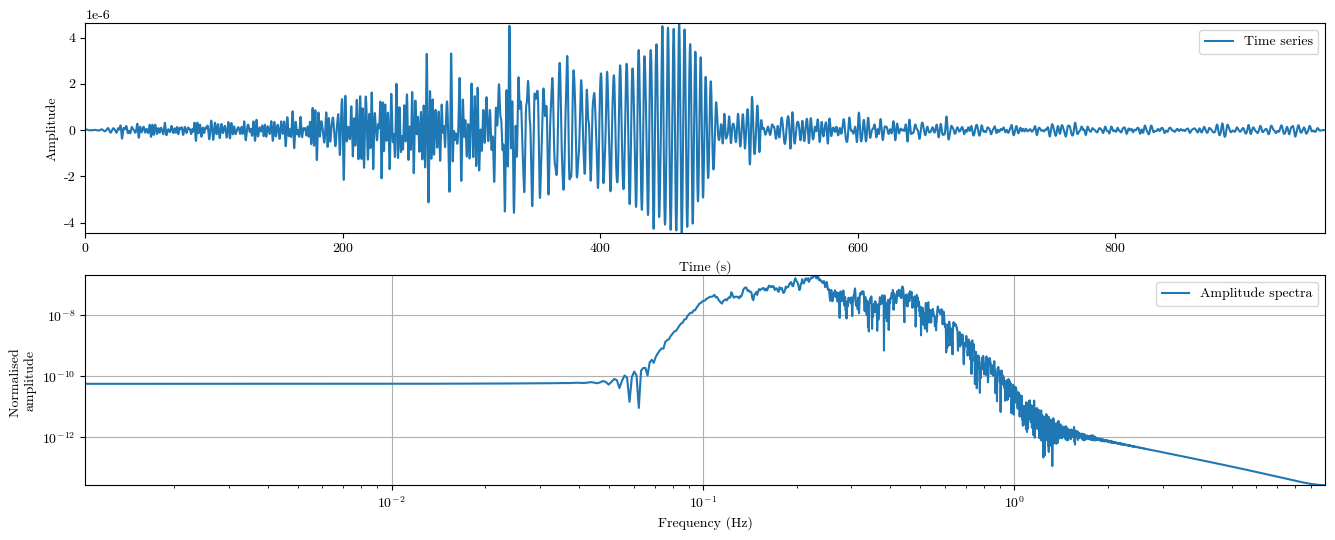

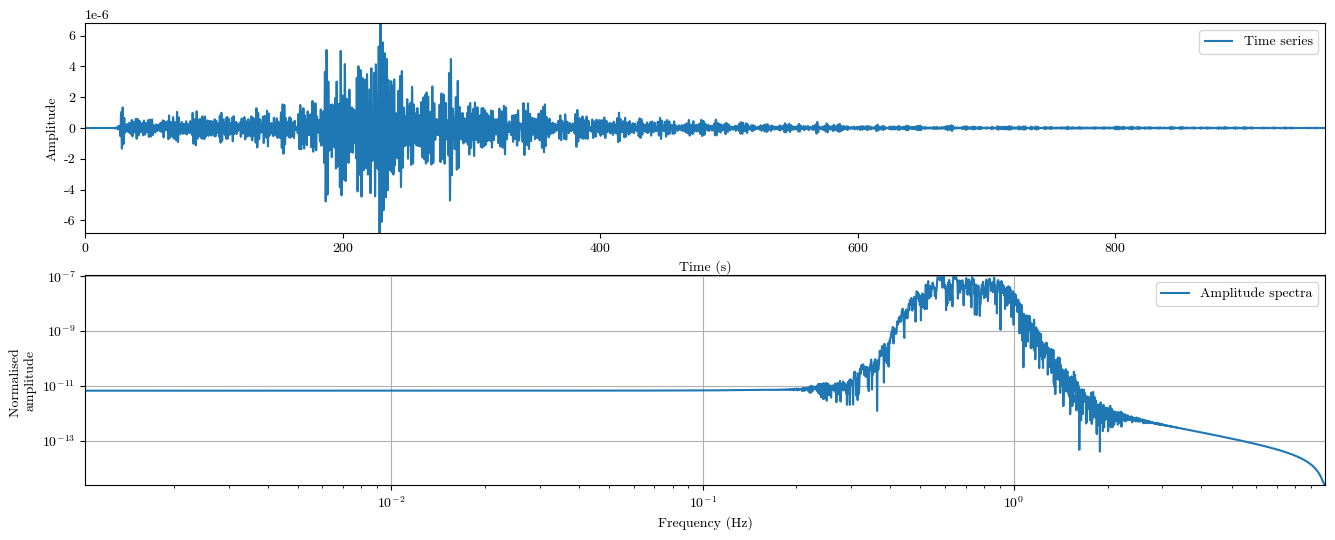

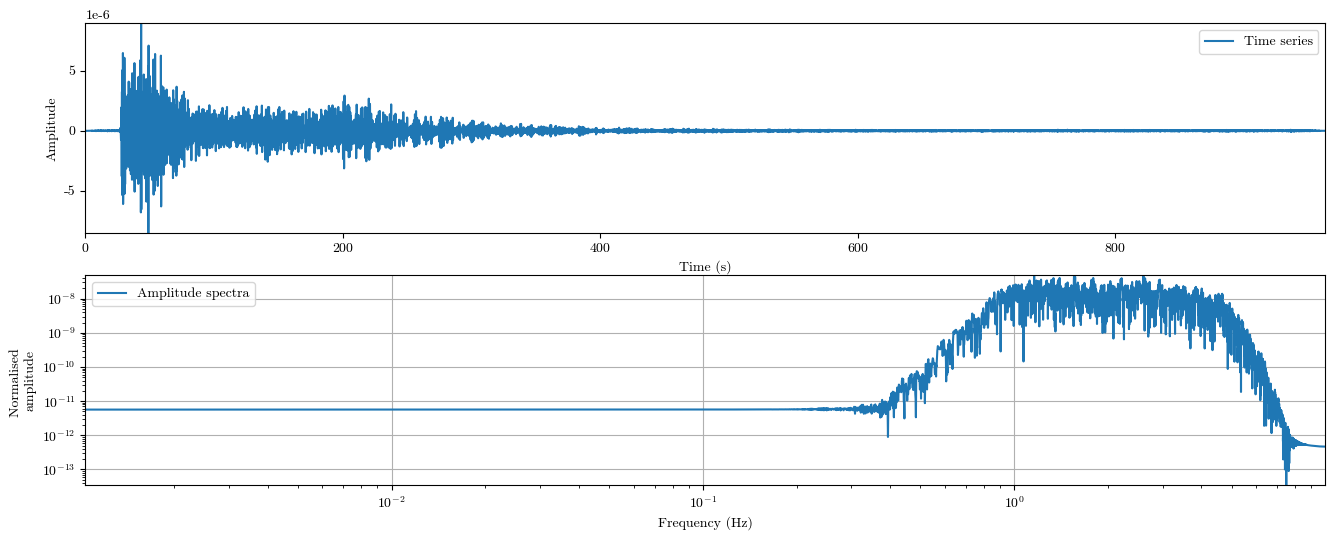

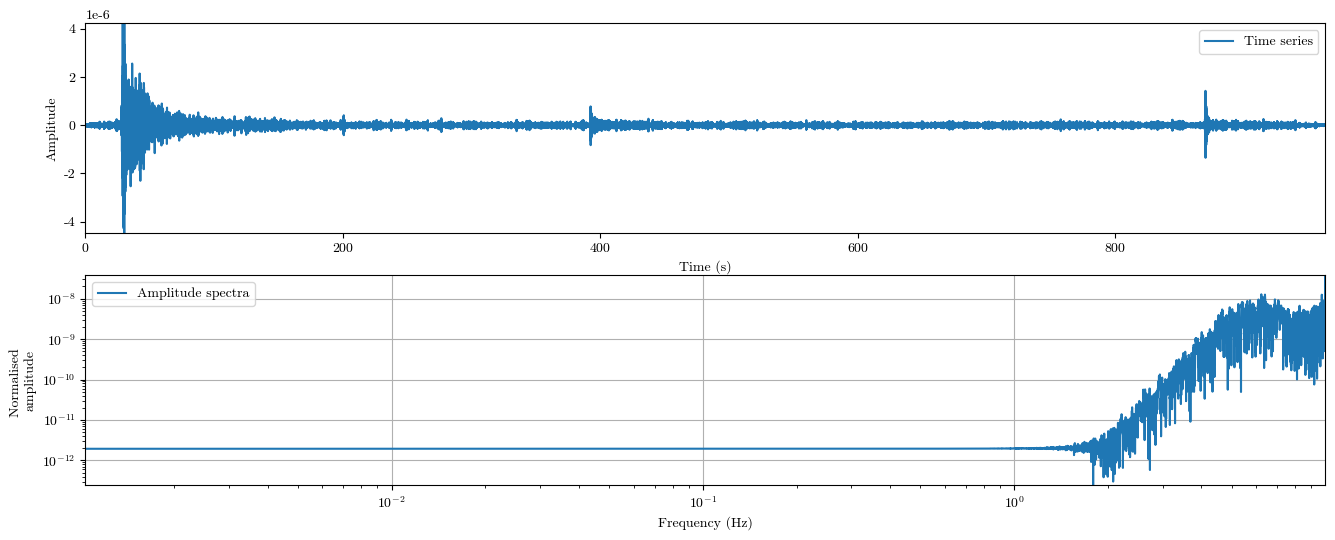

In [6]:
tr = read("../data/filter_test_1.mseed")[0]
tm = tr.times()
xmin = 0
xmax = 700

dat1 = tr.copy()
dat2 = tr.copy()
dat2.filter(type="bandpass", freqmin=0.01, freqmax=0.05, zerophase=True)
dat3 = tr.copy()
dat3.filter(type="bandpass", freqmin=0.05, freqmax=0.1, zerophase=True)
dat4 = tr.copy()
dat4.filter(type="bandpass", freqmin=0.1, freqmax=0.5, zerophase=True)
dat5 = tr.copy()
dat5.filter(type="bandpass", freqmin=0.5, freqmax=1, zerophase=True)
dat6 = tr.copy()
dat6.filter(type="bandpass", freqmin=1., freqmax=5., zerophase=True)
dat7 = tr.copy()
dat7.filter(type="bandpass", freqmin=5., freqmax=10., zerophase=True)

# 绘图
plt.rcParams['figure.figsize'] = 16, 6
x = np.arange(0, dat1.stats.npts * dat1.stats.delta, dat1.stats.delta)
y = dat1.data
fig = plot_fft(x, y, reconstruct=False)

x = np.arange(0, dat2.stats.npts * dat2.stats.delta, dat2.stats.delta)
y = dat2.data
fig = plot_fft(x, y, reconstruct=False)

x = np.arange(0, dat3.stats.npts * dat3.stats.delta, dat3.stats.delta)
y = dat3.data
fig = plot_fft(x, y, reconstruct=False)

x = np.arange(0, dat4.stats.npts * dat4.stats.delta, dat4.stats.delta)
y = dat4.data
fig = plot_fft(x, y, reconstruct=False)

x = np.arange(0, dat5.stats.npts * dat5.stats.delta, dat5.stats.delta)
y = dat5.data
fig = plot_fft(x, y, reconstruct=False)

x = np.arange(0, dat6.stats.npts * dat6.stats.delta, dat6.stats.delta)
y = dat6.data
fig = plot_fft(x, y, reconstruct=False)

x = np.arange(0, dat7.stats.npts * dat7.stats.delta, dat7.stats.delta)
y = dat7.data
fig = plot_fft(x, y, reconstruct=False)

### 4.滤波器设计

(1)低通滤波器

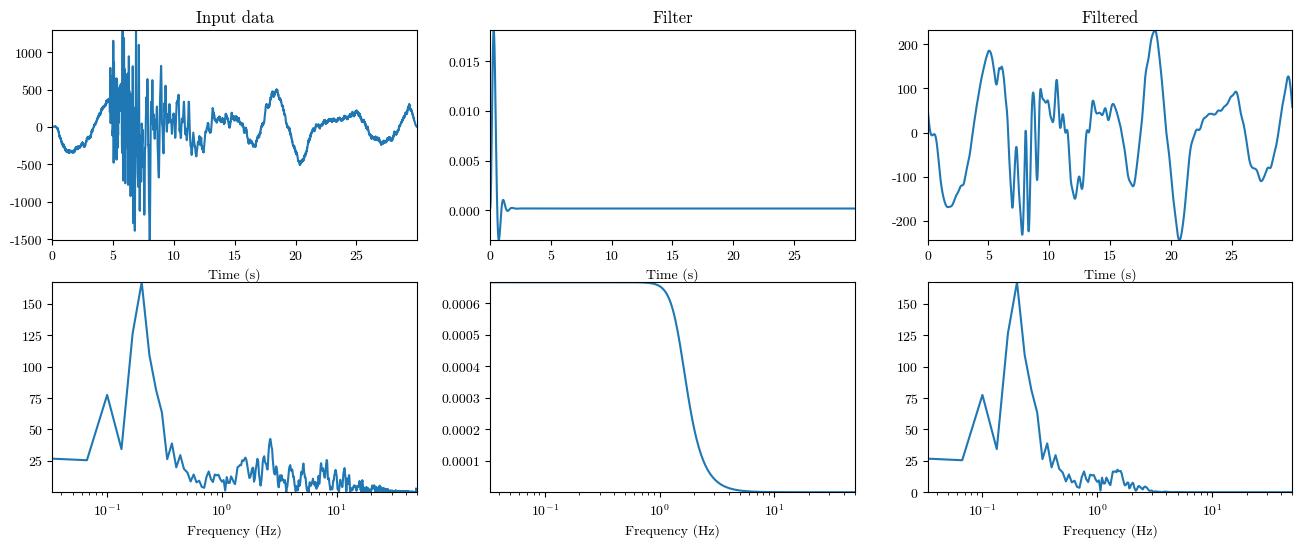

In [7]:
st = read("../data/test_trace.mseed")
tr = st[0]
tr = tr.detrend()  #滤波前先去除趋势

# corners: 转角频率
# order: 阶数
# window_type: 窗函数类型（'butter',‘cheby1','cheby2','ellip','bessel'）
# filter_type: 滤波器类型
filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[0.75], order=4, window_type="butter",
    filter_type="lowpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

(2)带通滤波器

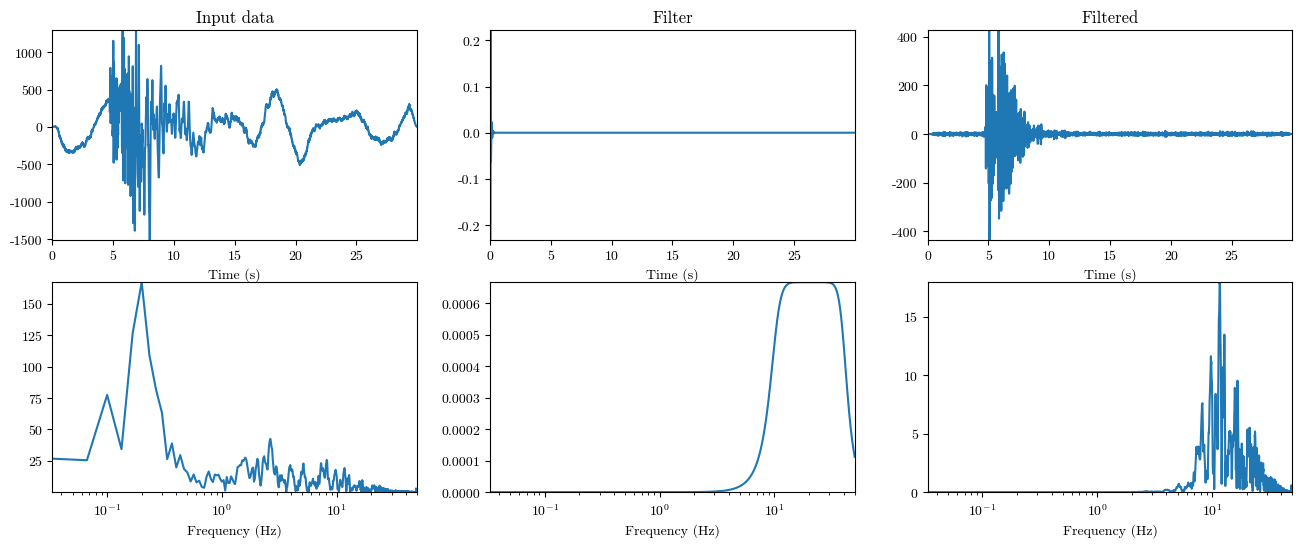

In [8]:
tr = read()[0]
tr = tr.detrend() #滤波前先去除趋势

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[5., 20.], order=4, window_type="butterworth",
    filter_type="bandpass", attenuation=10)
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

(3)高通滤波器

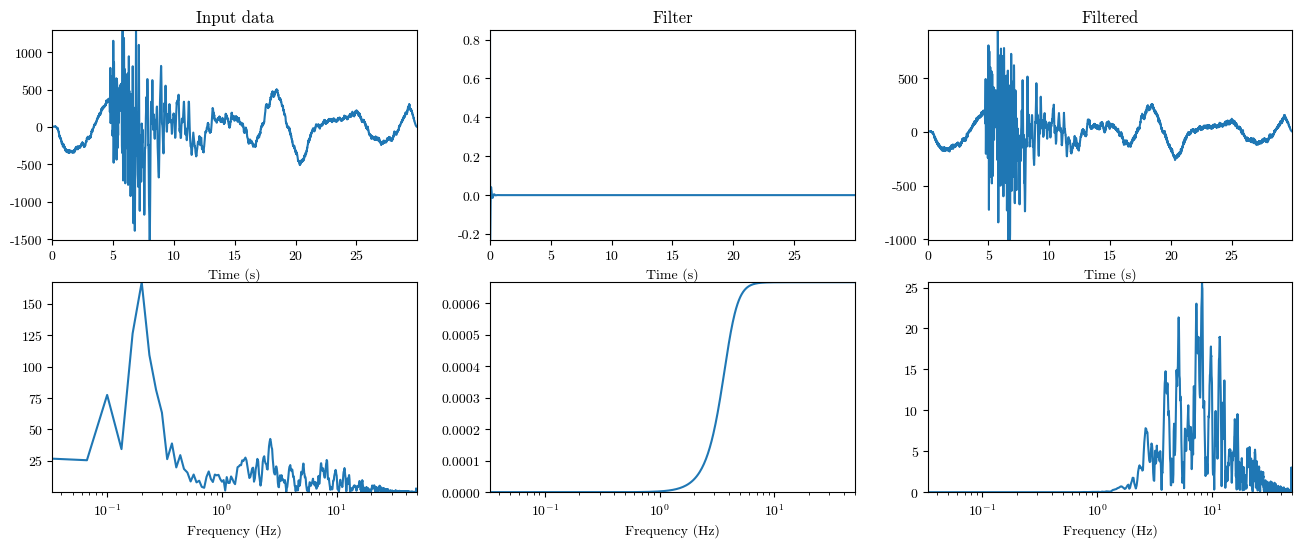

In [9]:
tr = read()[0]
tr = tr.detrend() #滤波前先去除趋势

filt = design_filter(
    sample_rate=tr.stats.sampling_rate, data_length=tr.stats.npts,
    corners=[2.], order=4, window_type="butter",
    filter_type="highpass")
fig = filter_and_plot(tr.data, tr.stats.delta, filt=filt)

### 5.零极点
滤波器通常以极点和零点的形式表示。极点和零点分别是传递函数的分母和分子的根。例如，如果我们有一个由以下定义的滤波器：
\begin{equation*}
    H(s) = \frac{s + 2}{s^2 + 0.25}
\end{equation*}
这个滤波器的零点将在$s=-2$，而极点将在$s=i\sqrt{0.25}, -i\sqrt{0.25}$.
巴特沃斯滤波器的传递函数采用以下形式，
\begin{equation*}
    G^2(\omega) = |H(i\omega)|^2 = \frac{G_0^2}{1 + \frac{i\omega}{i\omega_c}^{2n}}
\end{equation*}
其中，$\omega$ 是角频率，$\omega_c$ 是截止频率（在该频率处振幅增益降低50%），$G$ 是增益，$G_0$ 是直流增益（在频率为 $\omega=0$ 时的增益），$n$ 是滤波器的阶数。需要注意的是，滤波器的极点数等于 $2n$ 。
```
下面是 Butterworth 低通滤波器阶数的示例。需要注意的是，随着阶数的增加，斜率逐渐增加，接近不连续性。理想的滤波器应该能够去除所有不需要的频率并保留所有需要的频率而不进行衰减。在频率域中，这将呈现出一个阶跃的形状，然而，这种不连续性是不稳定的，并且会导致振铃现象。
```



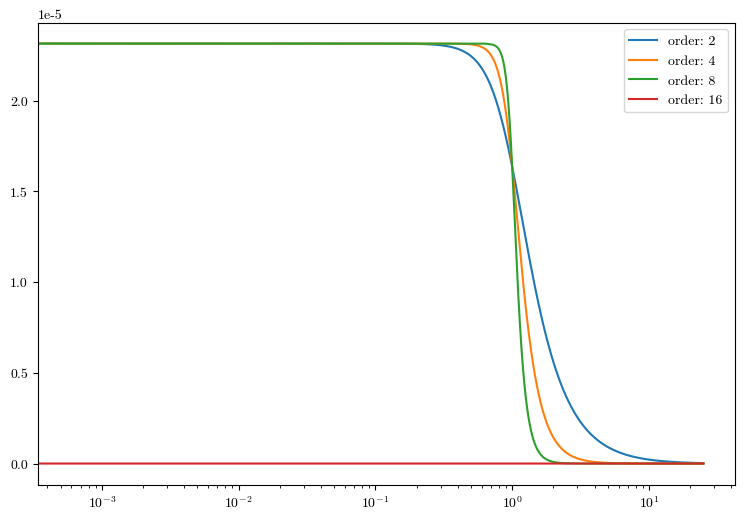

In [10]:
plt.rcParams['figure.figsize'] = 9, 6
fig, ax = plt.subplots()
N = 86400
sample_rate = 50
dt = 1 / sample_rate
for order in [2, 4, 8, 16]:
    filt = design_filter(
        sample_rate=sample_rate, data_length=N,
        corners=[0.5], order=order, window_type="butter",
        filter_type="lowpass")
    x_freq = np.linspace(0.0, 1.0 / (2. * dt), int(N / 2))
    ax.semilogx(x_freq, 2./N * np.abs(filt[:N//2]),
                label="order: {0}".format(order))
_ = ax.legend() 